In [1]:
from graph_class import *
from nltk_class import *
from text_mining import *
import warnings
sns.set_style('white')
update_parameter()
warnings.filterwarnings('ignore')

In [2]:
with open('twitter.json', 'r') as file:
    raw_tweet = pd.DataFrame(json.load(file))
print(f'Whole Tweet: {len(raw_tweet)}')

Whole Tweet: 48471


In [3]:
nlp = NltkTextProcessing()
tweet_no_hash = nlp.remove_hashtag_from_text(raw_tweet)
tweet_df = nlp.process_df_text_column(tweet_no_hash, stem=False) # steem
tweet_df = nlp.process_df_hash_column(tweet_df)
unique_tweet_df = nlp.keep_unique(tweet_df)

Tweets including retweets: 44588. Excluded: 9488


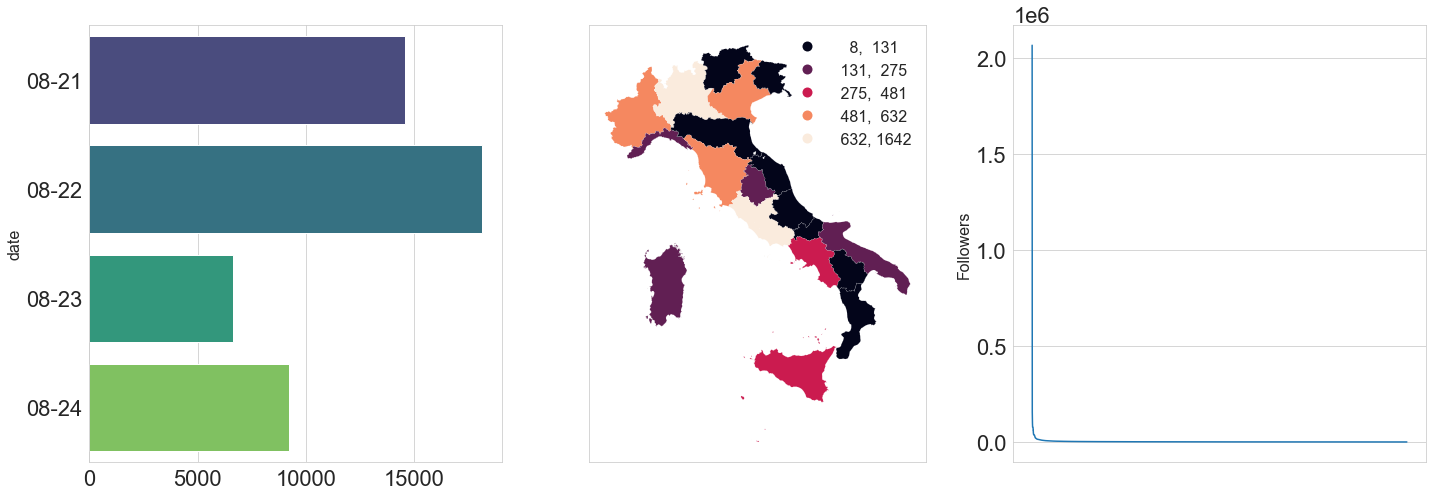

In [4]:
print(f"Tweets including retweets: {len(tweet_df)}. Excluded: {len(unique_tweet_df)}")
nlp.plot_dates_location_followers(raw_tweet)

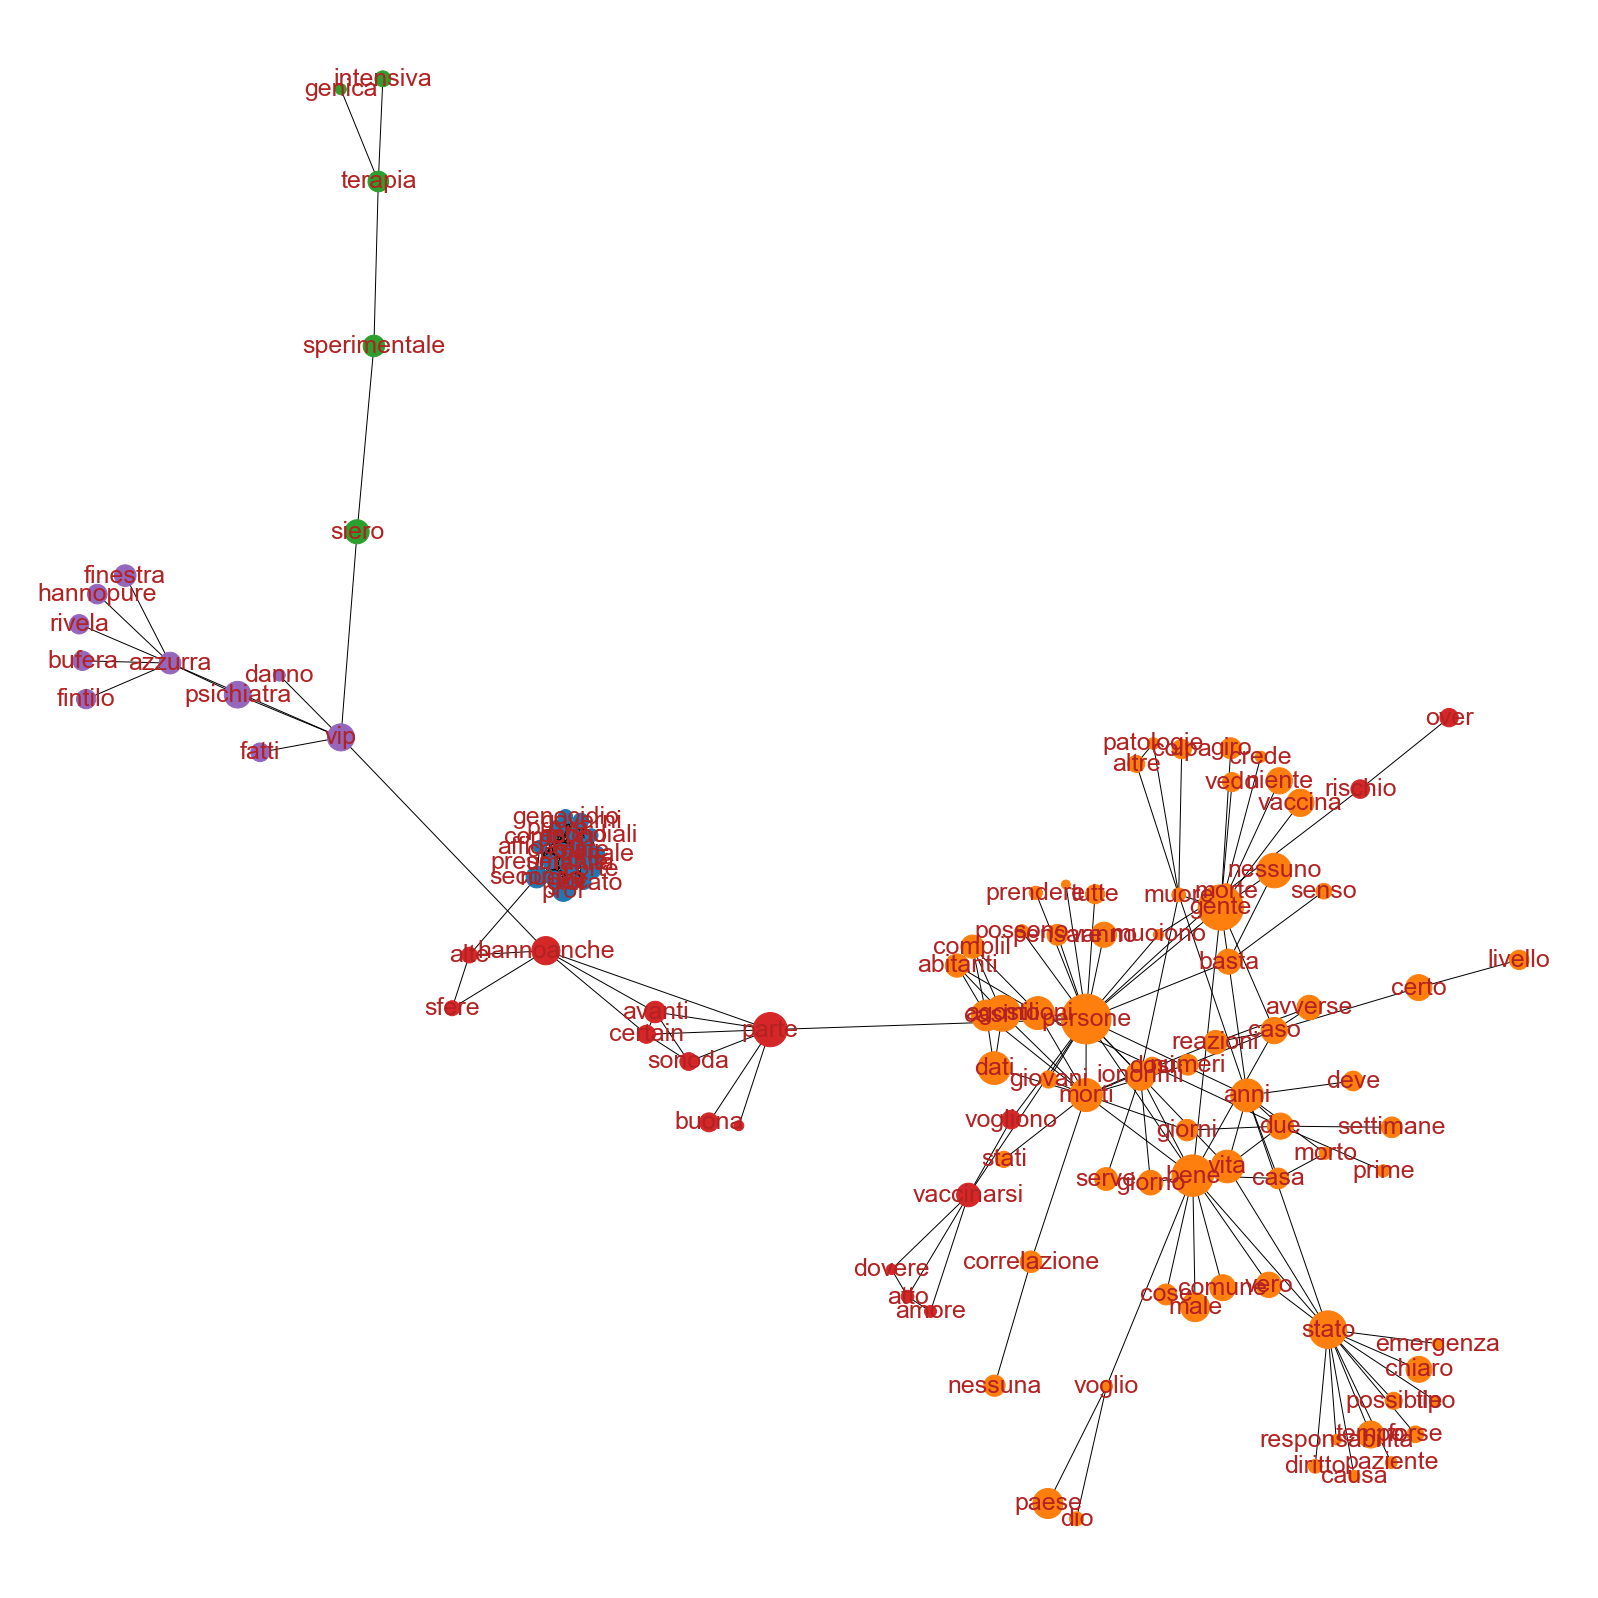

In [5]:
freq_distrib_tweet = nlp.frequency_dist(tweet_df, obj ='tweet') #tweet_df or unique_df?
graph_tweet = NetworkPlot.graph_filtered_dist(unique_tweet_df, freq_distrib_tweet, 70)
graph_tweet_filter = NetworkPlot.filter_pairwise_words(graph_tweet, 15)
NetworkPlot.keep_connected_components(graph_tweet_filter, min_degree = 15)
cluster_label = NetworkPlot.spectral_clustering(graph_tweet_filter, 5)
NetworkPlot(graph_tweet_filter, freq_distrib_tweet, label_thresold=100, labels=cluster_label).plot()

Averagle clustering of the network: 0.36865397860366905


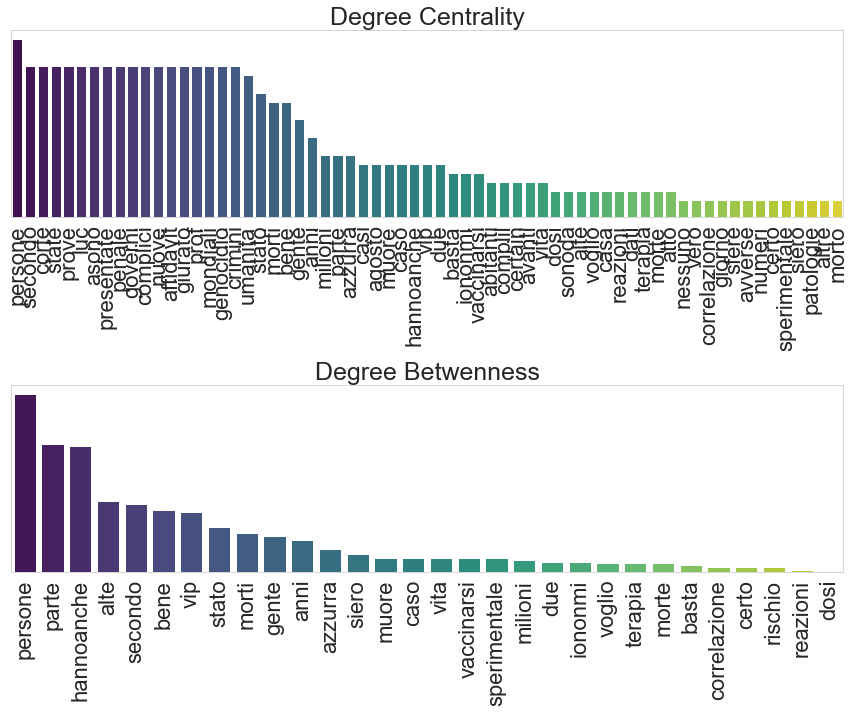

In [6]:
print(f"Averagle clustering of the network: {networkx.algorithms.cluster.average_clustering(graph_tweet_filter)}")

degree_centrality = networkx.algorithms.centrality.degree_centrality(graph_tweet_filter)
betweeneness_centrality = networkx.algorithms.centrality.betweenness_centrality(graph_tweet_filter)

NetworkPlot.plot_centrality([degree_centrality, betweeneness_centrality])

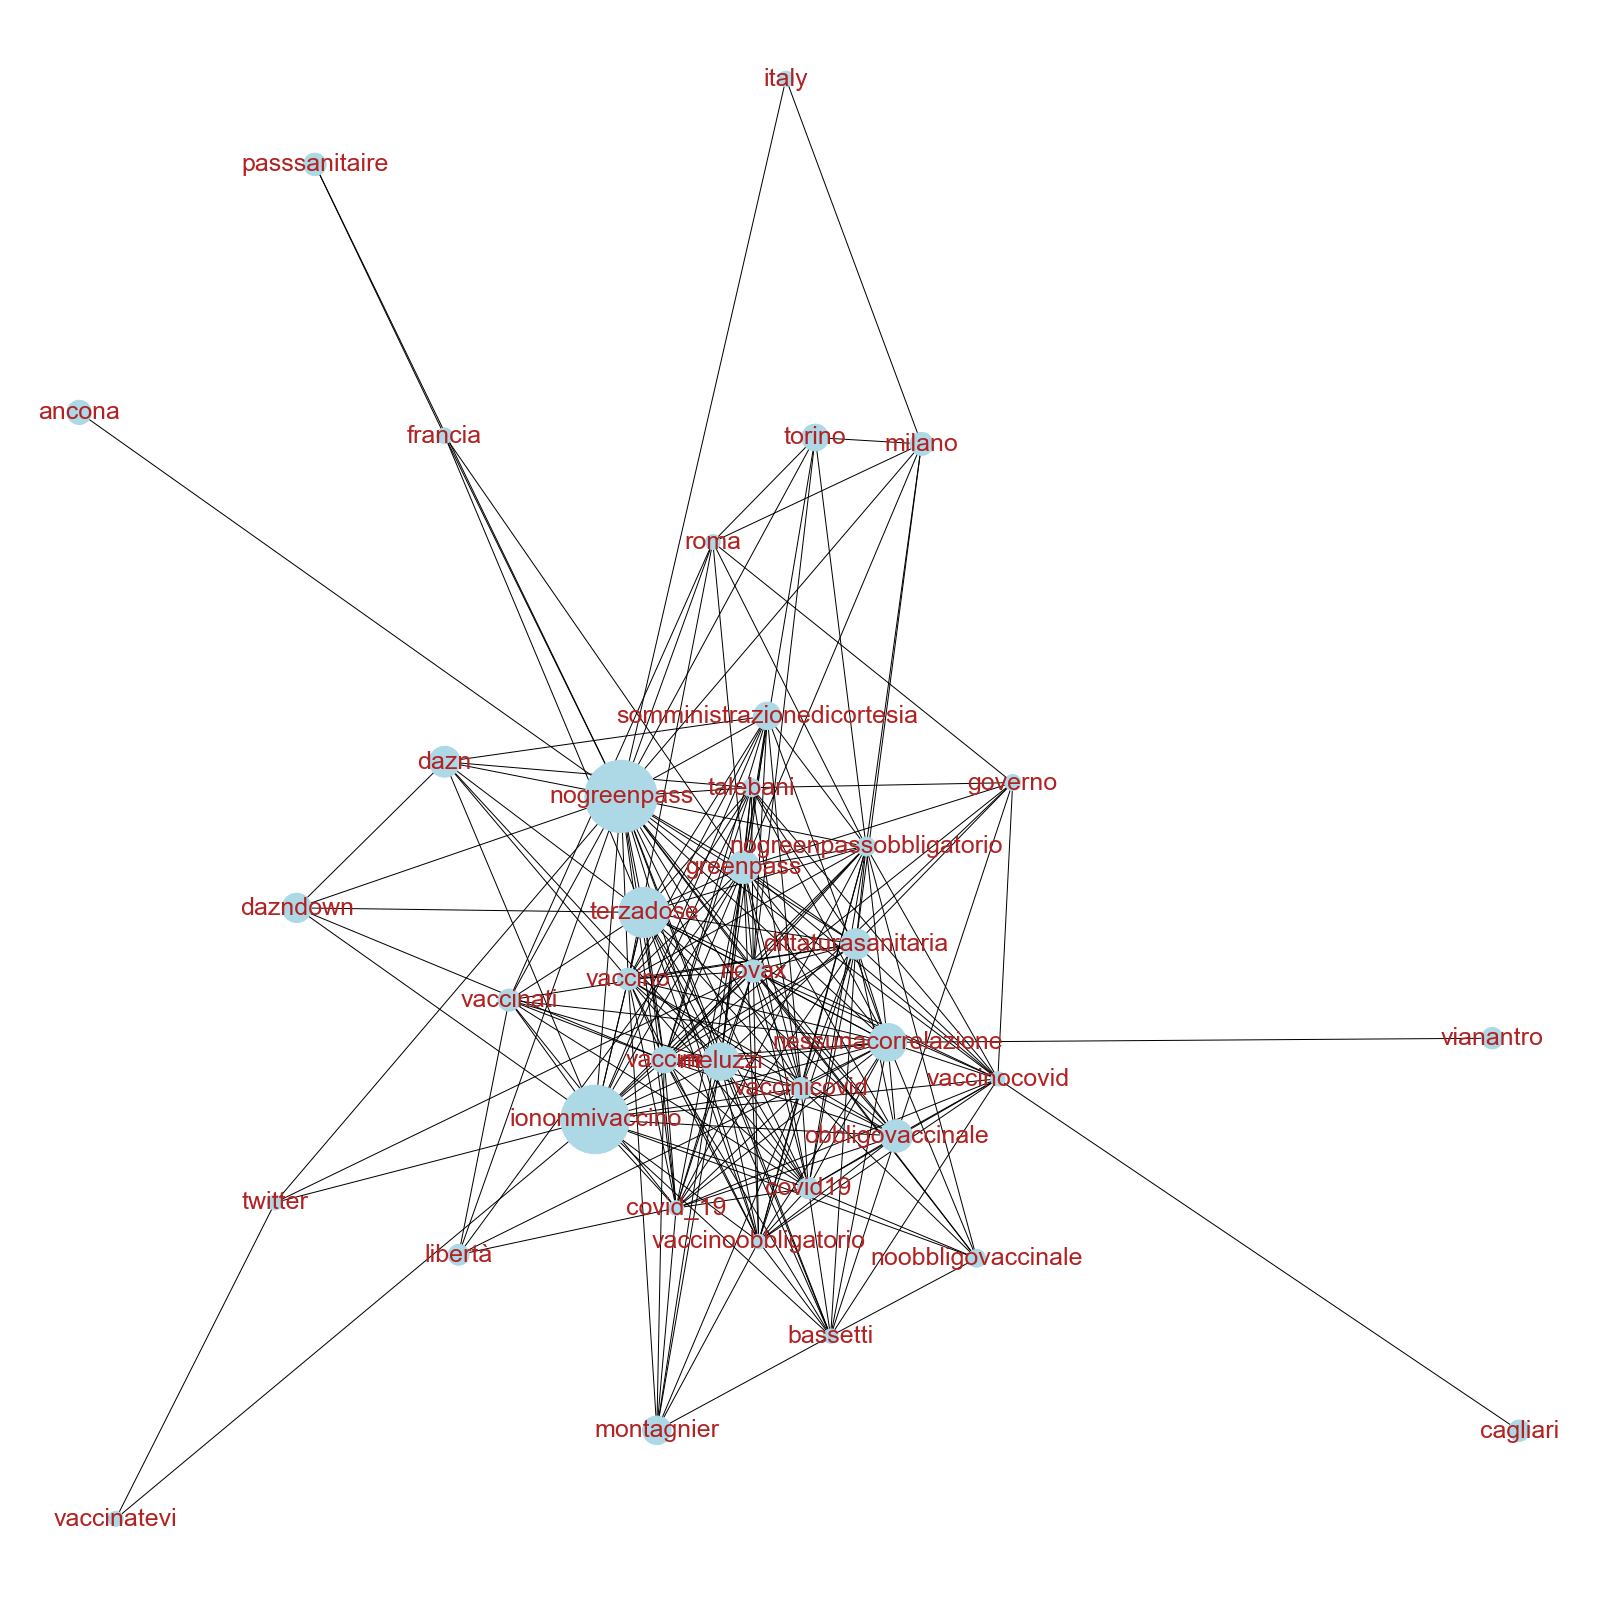

In [7]:
freq_distrib_hash = nlp.frequency_dist(tweet_df, obj ='hash')
graph_hash = NetworkPlot.graph_filtered_dist(df=unique_tweet_df, distrib=freq_distrib_hash, thresold=200, obj='hash')
NetworkPlot.keep_connected_components(graph_tweet_filter, min_degree = 5)
NetworkPlot(graph=graph_hash, frequency_dist=freq_distrib_hash, label_thresold=50, color_thresold=100).plot()

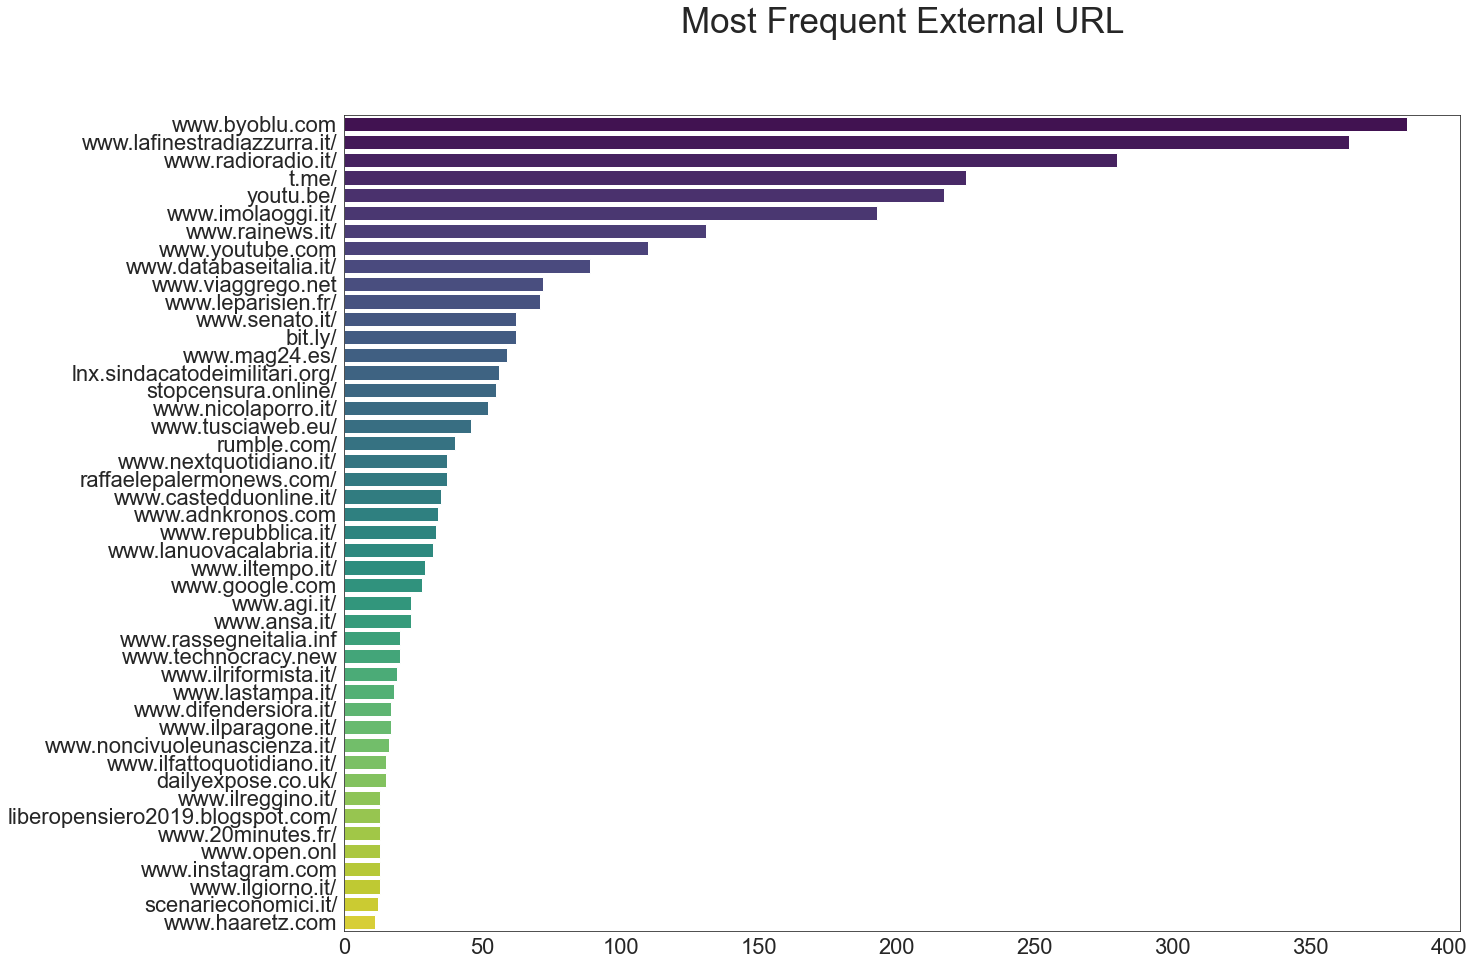

In [8]:
minium_thresold = 10 
NetworkPlot.count_barplot(nlp.extract_external_url(tweet_df), minium_thresold)

In [9]:
mining = TextMining()
text_to_vectorize = nlp.prepare_text_to_vectorize(unique_tweet_df, afil=True) # tweet_df
vectorized_text = mining.vectorized_text(text_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_text.shape}')

Shape of the Sparse matrix: (9488, 28688)


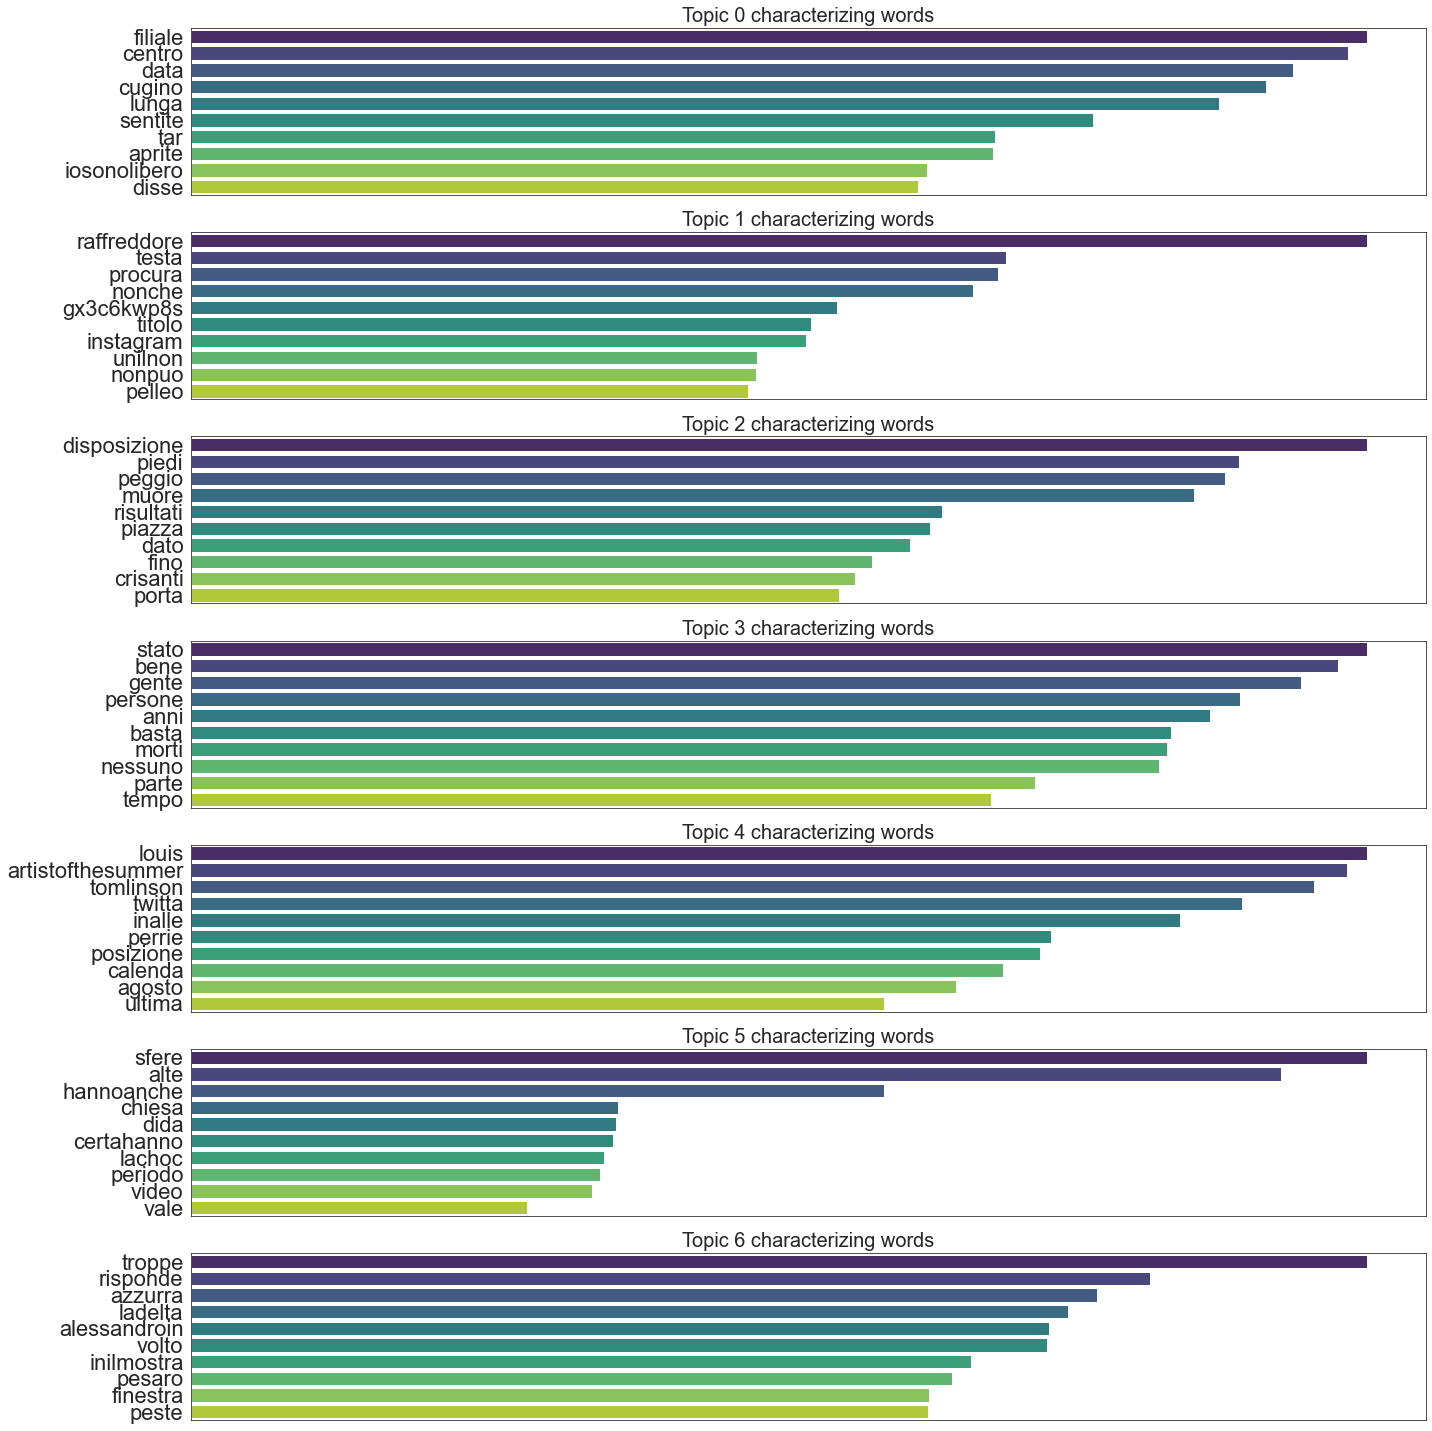

In [10]:
topics, top_word = 7, 10
lda_model, feature_names = mining.lda_topic_modeling(vectorized_text, topics)
mining.plot_lda_topic(lda_model, topics, n_top_words=top_word)

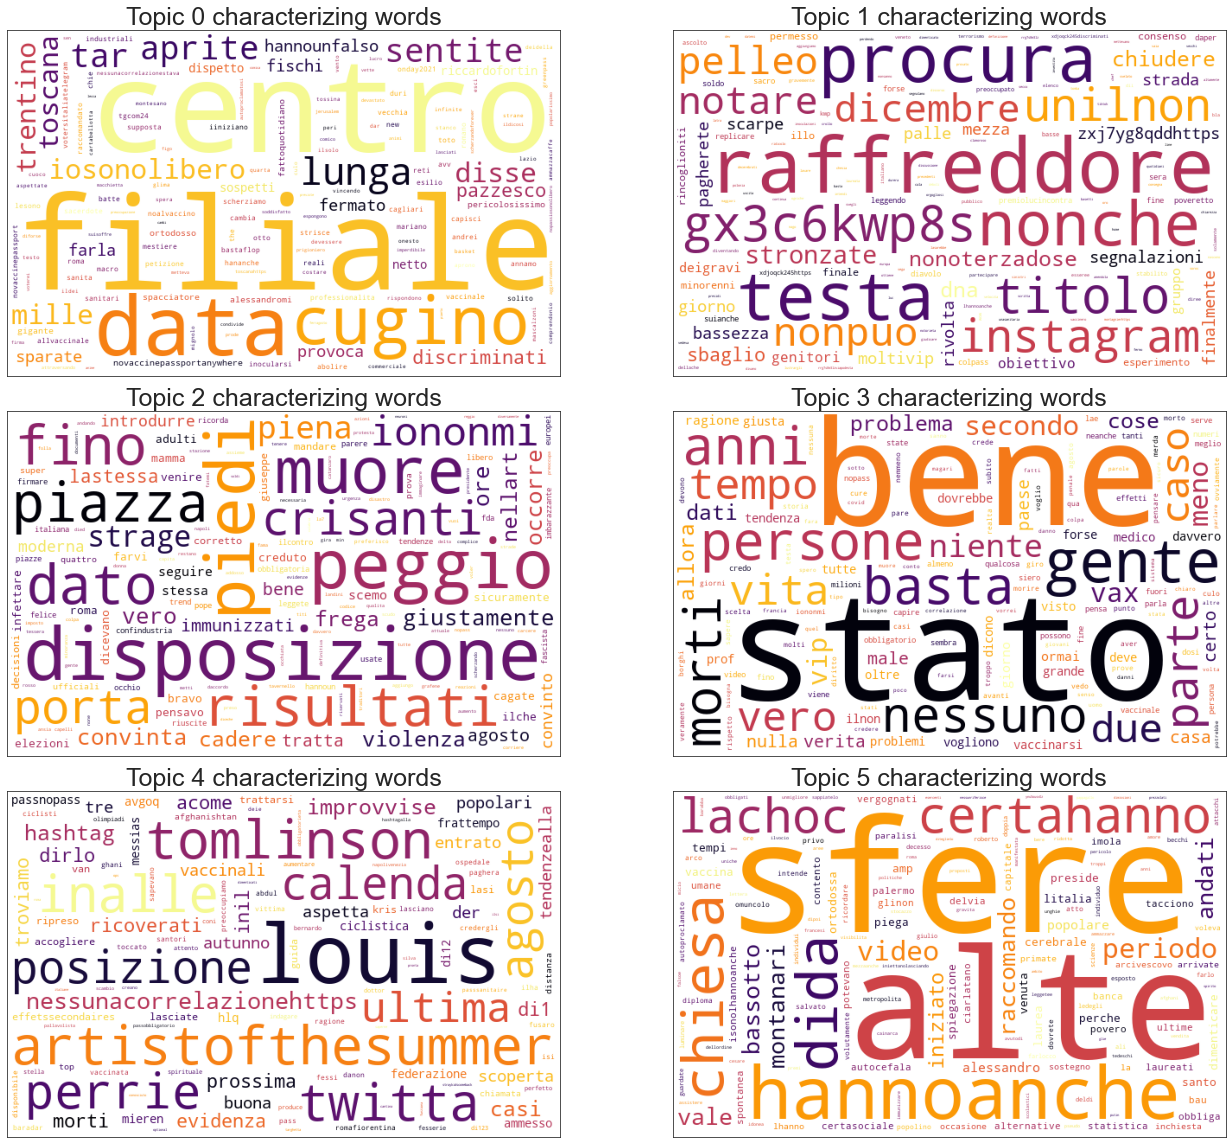

In [18]:
bag_of_words = mining.word_cloud_dict(lda_model)
mining.plot_wordcloud(bag_of_words, n_topics=6)

Explained variance of the SVD step: 0.18641287393135206%


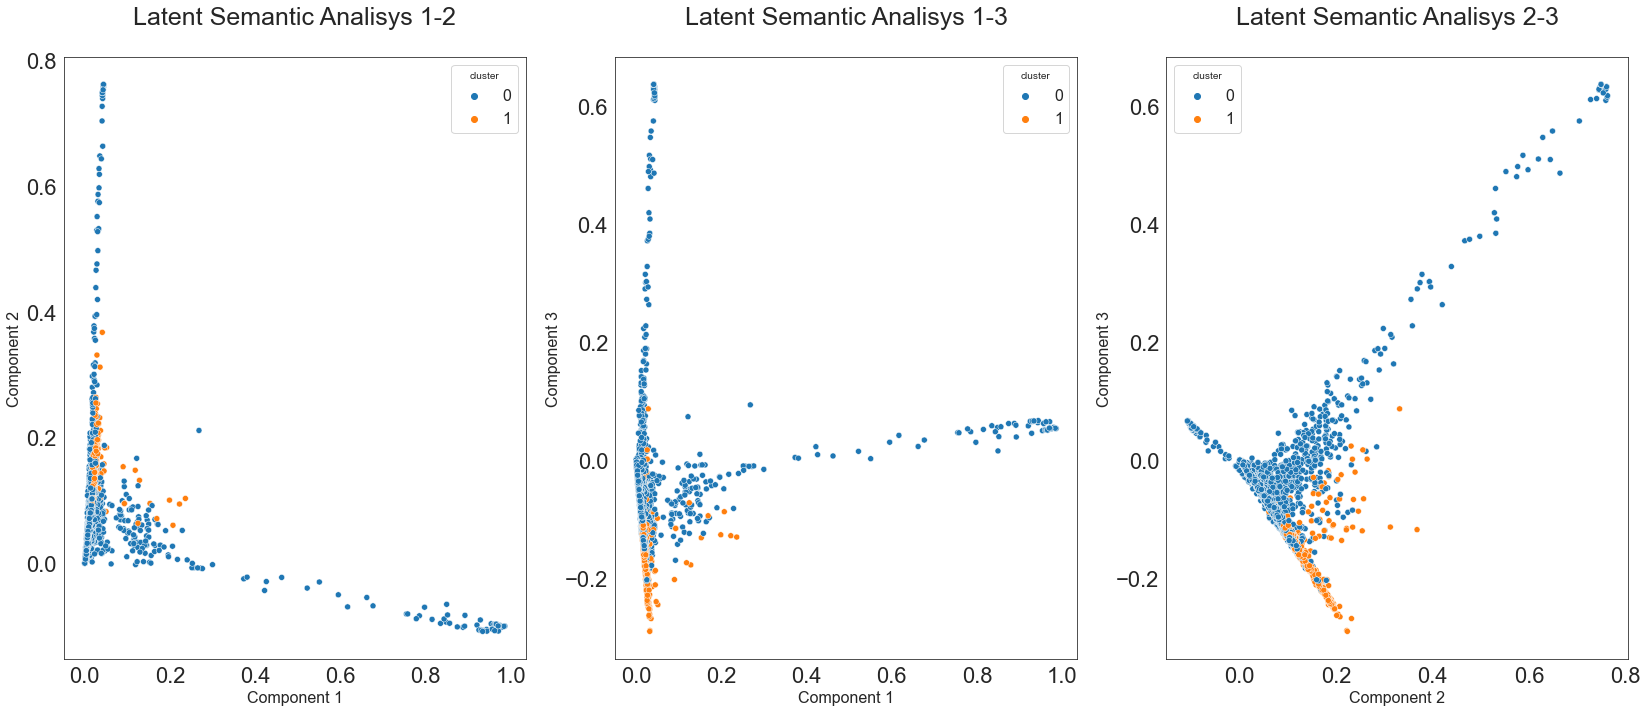

In [12]:
n_components = 300
svd_model, svd_result = mining.latent_semantic_analysis(vectorized_text, n_components)
kmeans = mining.clustering_kmeans(svd_result, 2)
mining.plot_lsa(svd_result, kmeans, n_components)

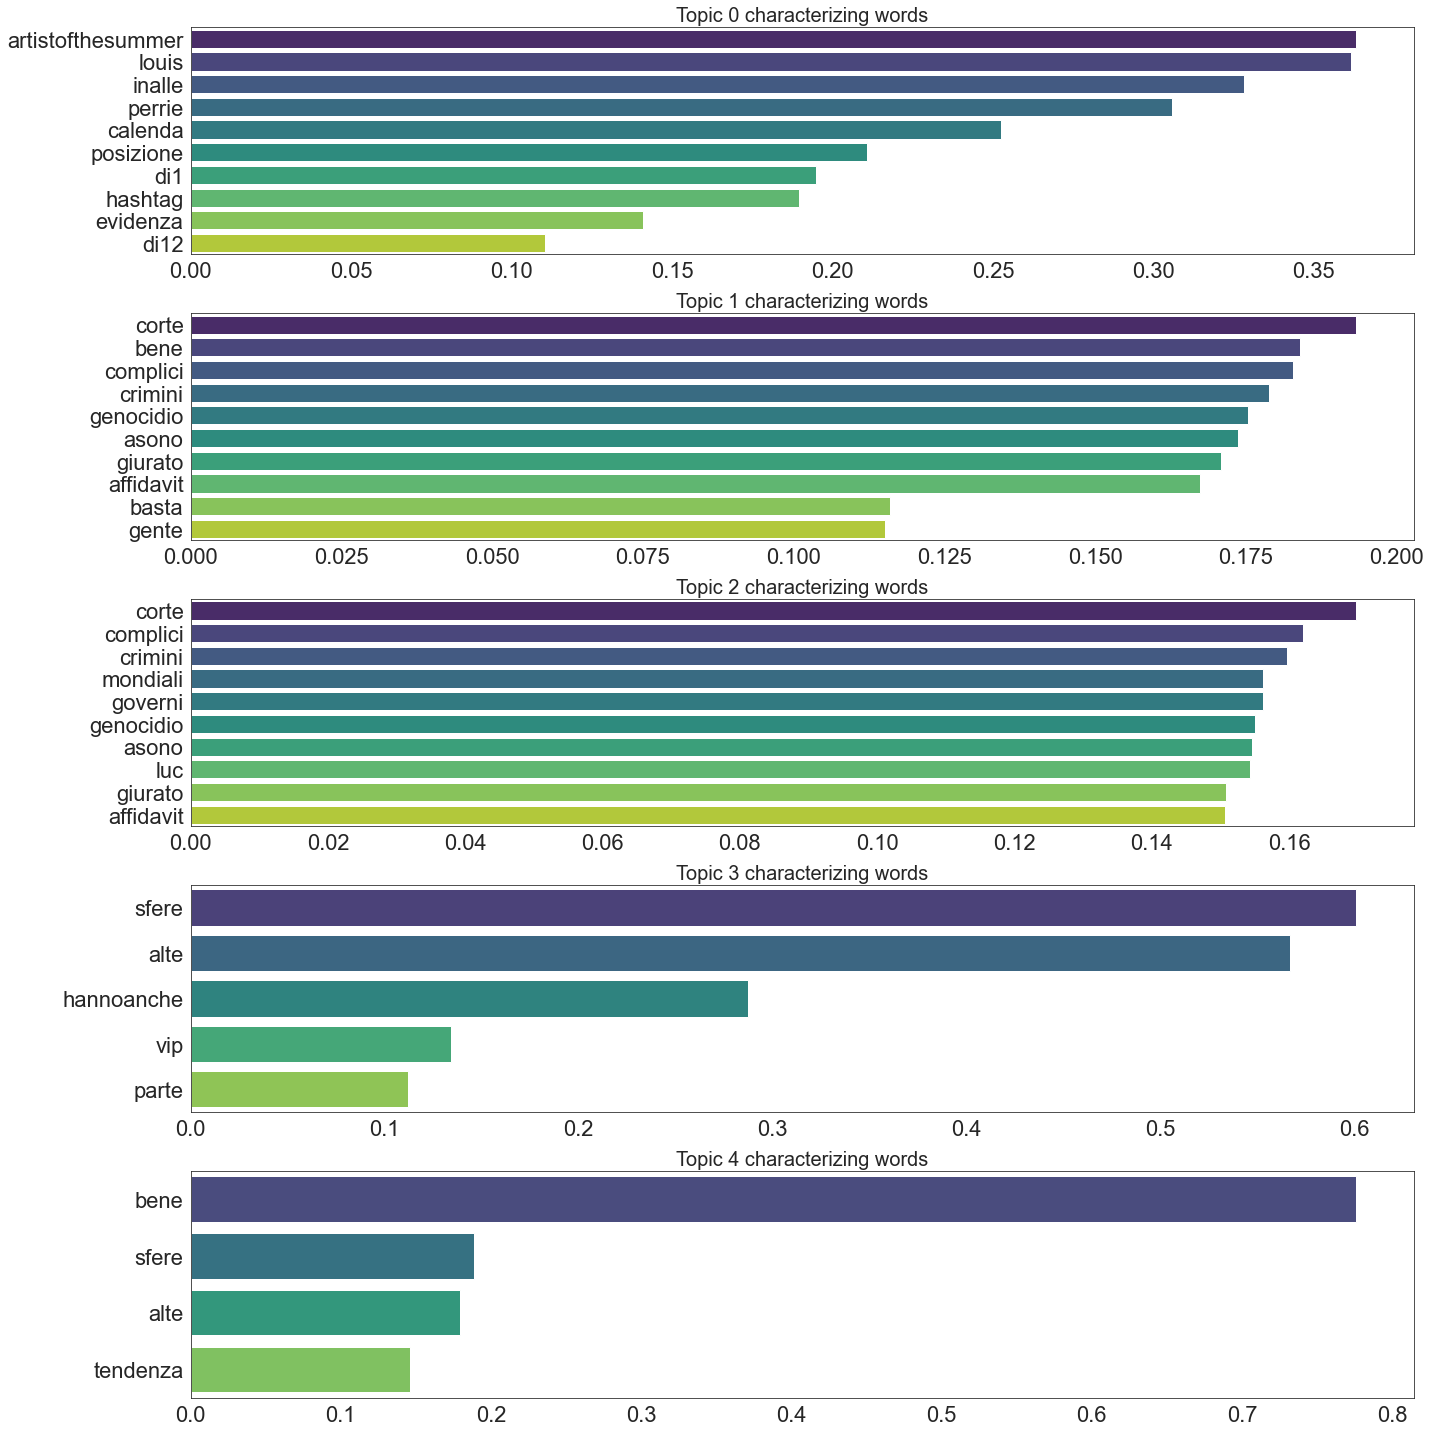

In [13]:
mining.plot_lsa_topic(svd_model, topics=5, top_word=10)

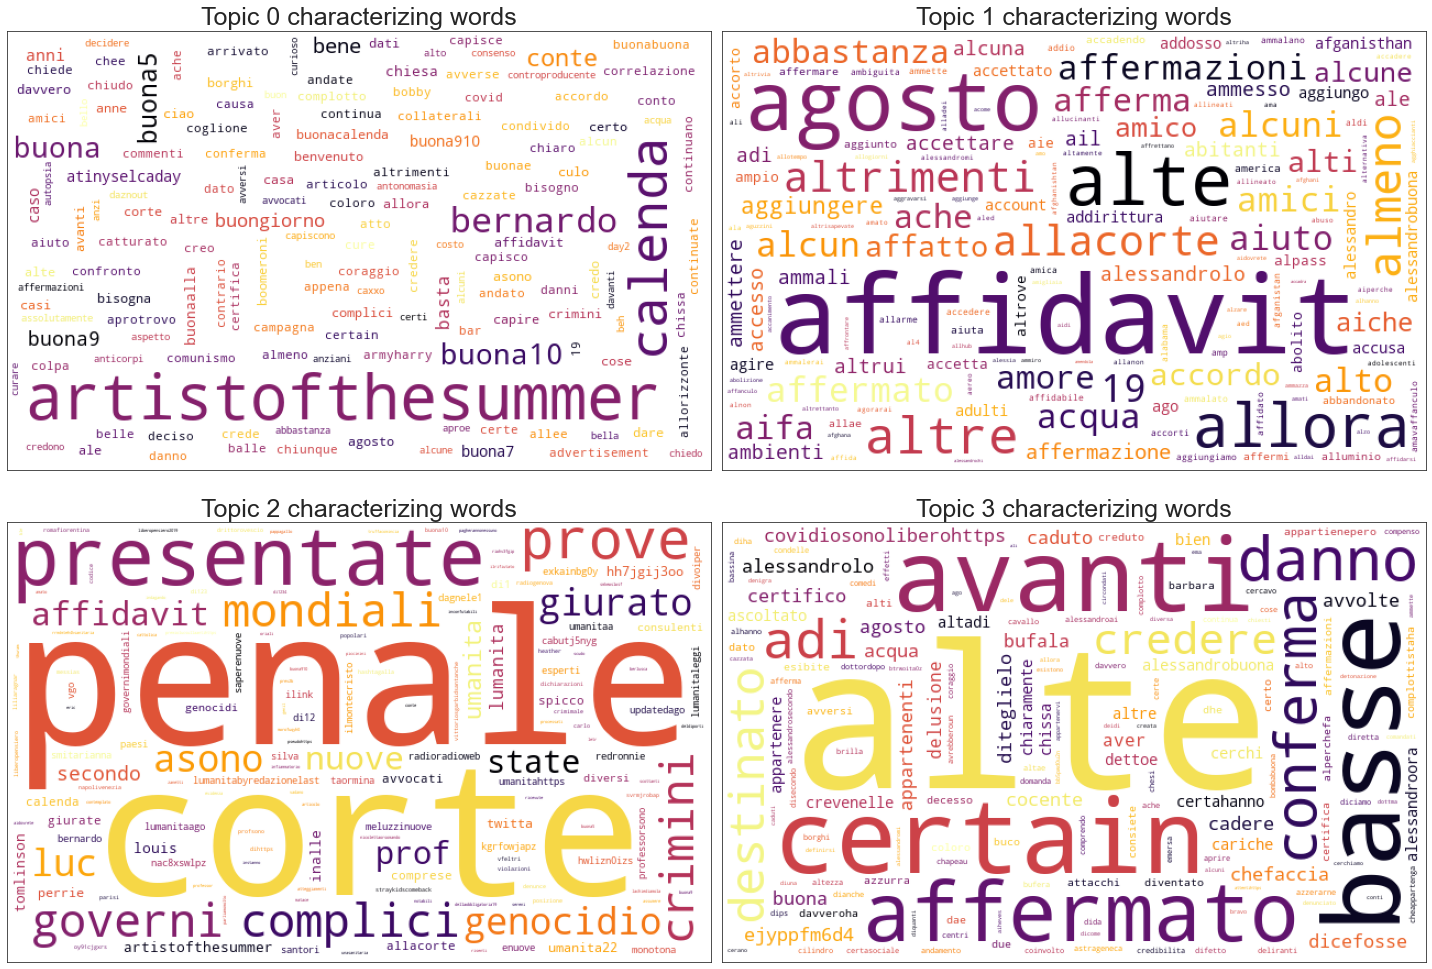

In [17]:
datas = mining.get_wordcloud_lsa(svd_model, topics=4)
mining.plot_wordcloud(datas, n_topics=4)

neighbours = [3,7,10,15]
umap_reduced = [mining.umaps(vectorized_text, k=i) for i in neighbours] #svd_result or vectorized_text?
mining.plot_umaps(umap_reduced, n_cluster=3, k=neighbours)

# HASHTAGS

mining = TextMining()
hash_to_vectorize = nlp.prepare_text_to_vectorize(unique_df, afil=True) # tweet_df
vectorized_hash = mining.vectorized_text(hash_to_vectorize)
print(f'Shape of the Sparse matrix: {vectorized_hash.shape}')

lda_model_hash, feature_names_hash = mining.lda_topic_modeling(vectorized_hash, 3)
mining.plot_lda_topic(lda_model_hash, 10)

n_components = 300
svd_result_hash = mining.latent_semantic_analysis(vectorized_hash, n_components)
kmeans = mining.clustering_kmeans(svd_result_hash, 3)
mining.plot_lsa(svd_result_hash, kmeans, n_components)

neighbours = [3,7,10,15]
umap_reduced_hash = [mining.umaps(vectorized_hash, k=i) for i in neighbours]
mining.plot_umaps(umap_reduced_hash, n_cluster=3, k=neighbours)

import geopandas as gpd
italy_path ="https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_regions.geojson" #reg_name
italy = gpd.read_file(italy_path) # usual path
italy.loc[italy.reg_name == 'Trentino-Alto Adige/Südtirol', "reg_name"] = 'Trentino-Alto Adige'
with open('citta.json', 'r') as file:
    location = json.load(file)
region = inv_map = set(location.values())
punct = ['-','_','/',',','.','!','?']
flag,res = True, list()
for row in raw_tweet.author_loc.dropna():
    for p in punct:
        tmp = row.replace(p, ' ')
    for word in tmp.split(' '):
        if word in location:
            res.append(location[word])
            flag = False
    if flag:
        for word in tmp.split(' '):
            if word in region:
                res.append(word)
    flag = True
name, count = np.unique(res, return_counts=True)
loc = dict(zip(name, count))
loc = pd.DataFrame(loc, index=[0]).T.reset_index().rename(columns={'index': 'reg_name', 0: 'value'})
loc.loc[loc.reg_name == 'Trentino-Alto Adige/S�dtirol', ['reg_name']] = 'Trentino-Alto Adige'
merged = pd.merge(italy, loc, on='reg_name')
fig, axes= plt.subplots(figsize=(10,10))
merged.plot(ax=axes,
           column='value',
           linewidth = 0.1,
           scheme="NaturalBreaks", k=5,
           cmap = "cividis",
           aspect= 'auto',
           legend=True,      
           markersize=100,
           legend_kwds = dict(fmt = '{:.0f}', frameon=False, loc='lower left'))
plt.show()